In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:75%} </style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras import applications

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4.2)]
#         )
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

#     except RuntimeError as e:
#         print(e)

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Training parameters and variables

In [5]:
histories = {}
epochs = 125
batch_size = 512

## Downloading and splitting data

This dataset does not provide test part so we'll split training data into 70-15-15 as train, validate and test parts.

In [6]:
(dataset_train_raw, dataset_validate_raw, dataset_test_raw), info = tfds.load(
    name="eurosat/rgb",
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:70]),
        tfds.Split.TRAIN.subsplit(tfds.percent[70:85]),
        tfds.Split.TRAIN.subsplit(tfds.percent[85:])
    ],
    with_info=True,
    as_supervised=True
)

print(info)
print("Train:   ", len(list(dataset_train_raw)))
print("Validate:", len(list(dataset_validate_raw)))
print("Test:    ", len(list(dataset_test_raw)))


tfds.core.DatasetInfo(
    name='eurosat',
    version=0.0.1,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    urls=['https://github.com/phelber/eurosat'],
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
       

In [7]:
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea or lake"]

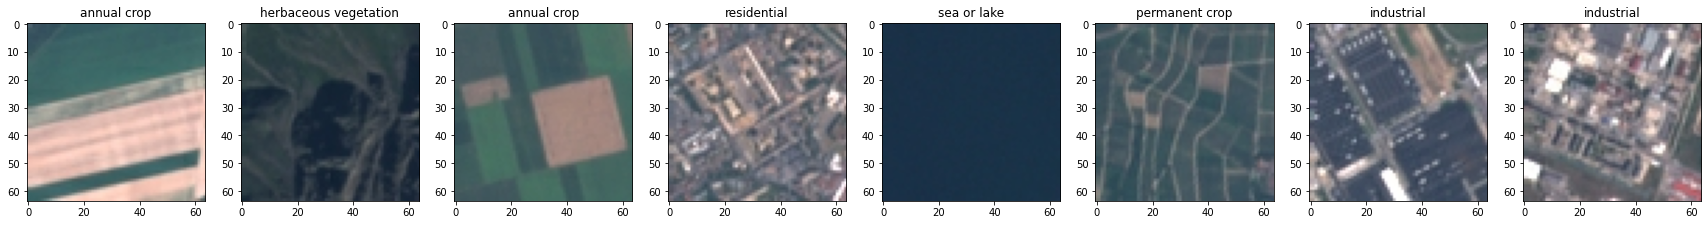

In [8]:
sample_size = 8

plt.figure(figsize=(30, 8))

for index, (image, label) in enumerate(dataset_train_raw.take(sample_size)):
    
    plt.subplot(1, sample_size, index + 1)
    plt.imshow(image)
    plt.title(class_names[label])

## Preprocessing data

In [9]:
def encode(image, label):
    
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label = tf.one_hot(label, depth=len(class_names))
    
    return image, label
    
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

print(data_train)

<CacheDataset shapes: ((64, 64, 3), (10,)), types: (tf.float32, tf.float32)>


## Define Neural Network base architecture

In [10]:
model = models.Sequential()

# Conv 32 block; kernel 3x3
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=(64, 64, 3)))
model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Conv 64 block; kernel 3x3
model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Conv 128 block; kernel 3x3
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(2, 2))

# Latent space
model.add(layers.Flatten())

# Classifier
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       7

### Define compiler

In [11]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Create Base Model
### Model evaluation before training

In [12]:
loss, acc = model.evaluate(data_test.batch(32))

print("Evaluation with randomly initialized weights")
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

127/127 [==============================] - 10s 79ms/step - loss: 2.2989 - accuracy: 0.0958
Evaluation with randomly initialized weights
Loss: 2.2989437580108643
Accuracy: 0.09580247104167938


### Training baseline ANN model

In [13]:
history = model.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["baseline"] = history

Epoch 1/125
37/37 [==============================] - 59s 2s/step - loss: 2.0252 - accuracy: 0.2233 - val_loss: 1.6785 - val_accuracy: 0.3417
Epoch 2/125
37/37 [==============================] - 6s 172ms/step - loss: 1.5076 - accuracy: 0.4028 - val_loss: 1.3782 - val_accuracy: 0.4244
Epoch 3/125
37/37 [==============================] - 6s 172ms/step - loss: 1.2954 - accuracy: 0.4854 - val_loss: 1.2467 - val_accuracy: 0.5025
Epoch 4/125
37/37 [==============================] - 6s 172ms/step - loss: 1.1548 - accuracy: 0.5442 - val_loss: 1.0988 - val_accuracy: 0.6012
Epoch 5/125
37/37 [==============================] - 6s 173ms/step - loss: 1.0161 - accuracy: 0.6288 - val_loss: 0.9814 - val_accuracy: 0.6405
Epoch 6/125
37/37 [==============================] - 6s 174ms/step - loss: 0.8458 - accuracy: 0.6943 - val_loss: 0.8647 - val_accuracy: 0.6743
Epoch 7/125
37/37 [==============================] - 6s 174ms/step - loss: 0.7478 - accuracy: 0.7282 - val_loss: 0.7463 - val_accuracy: 0.7400
E

Epoch 58/125
37/37 [==============================] - 7s 182ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 1.0664 - val_accuracy: 0.8499
Epoch 59/125
37/37 [==============================] - 7s 186ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 1.0604 - val_accuracy: 0.8536
Epoch 60/125
37/37 [==============================] - 7s 188ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.1030 - val_accuracy: 0.8533
Epoch 61/125
37/37 [==============================] - 8s 208ms/step - loss: 7.5931e-04 - accuracy: 0.9999 - val_loss: 1.1210 - val_accuracy: 0.8516
Epoch 62/125
37/37 [==============================] - 8s 209ms/step - loss: 5.5717e-04 - accuracy: 0.9999 - val_loss: 1.1456 - val_accuracy: 0.8526
Epoch 63/125
37/37 [==============================] - 7s 201ms/step - loss: 6.7991e-04 - accuracy: 0.9999 - val_loss: 1.1461 - val_accuracy: 0.8546
Epoch 64/125
37/37 [==============================] - 7s 199ms/step - loss: 4.1066e-04 - accuracy: 1.0000 - val_loss: 1.1607

37/37 [==============================] - 7s 191ms/step - loss: 3.3666e-05 - accuracy: 1.0000 - val_loss: 1.3807 - val_accuracy: 0.8553
Epoch 114/125
37/37 [==============================] - 7s 197ms/step - loss: 3.2688e-05 - accuracy: 1.0000 - val_loss: 1.3873 - val_accuracy: 0.8551
Epoch 115/125
37/37 [==============================] - 7s 196ms/step - loss: 3.2011e-05 - accuracy: 1.0000 - val_loss: 1.3917 - val_accuracy: 0.8543
Epoch 116/125
37/37 [==============================] - 7s 192ms/step - loss: 3.0952e-05 - accuracy: 1.0000 - val_loss: 1.3947 - val_accuracy: 0.8541
Epoch 117/125
37/37 [==============================] - 7s 195ms/step - loss: 2.9993e-05 - accuracy: 1.0000 - val_loss: 1.4019 - val_accuracy: 0.8548
Epoch 118/125
37/37 [==============================] - 7s 189ms/step - loss: 2.8880e-05 - accuracy: 1.0000 - val_loss: 1.4028 - val_accuracy: 0.8553
Epoch 119/125
37/37 [==============================] - 7s 201ms/step - loss: 2.7249e-05 - accuracy: 1.0000 - val_loss: 1

In [14]:
def plot_history(history):
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.show()
    plt.close()

### Evaluation of training process

#### Significant overfitting, we proceed with next steps to deal with that. Let's start with Dropout layers

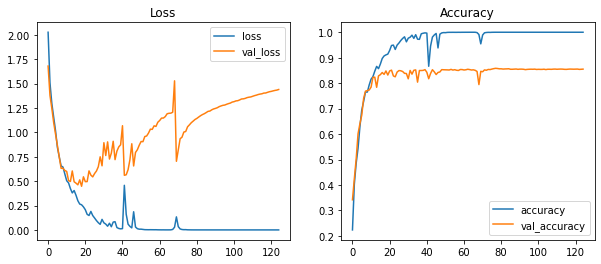

In [15]:
plot_history(history)

## Reduce overfitting - step 1
### Dropout layers

In [16]:
model_2 = models.Sequential()

# Conv 32 block; kernel 3x3
model_2.add(layers.Conv2D(32, (3,3), activation="swish", padding="same", input_shape=(64, 64, 3)))
model_2.add(layers.Conv2D(32, (3,3), activation="swish", padding="same"))
model_2.add(layers.MaxPooling2D(2, 2))
model_2.add(layers.Dropout(0.2))

# Conv 64 block; kernel 3x3
model_2.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model_2.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model_2.add(layers.MaxPooling2D(2, 2))
model_2.add(layers.Dropout(0.3))

# Conv 128 block; kernel 3x3
model_2.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model_2.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model_2.add(layers.MaxPooling2D(2, 2))
model_2.add(layers.Dropout(0.4))

# Latent space
model_2.add(layers.Flatten())

# Classifier
model_2.add(layers.Dense(128, activation="swish"))
model_2.add(layers.Dropout(0.4))
model_2.add(layers.Dense(10, activation="softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

### Preprocessing

In [17]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

### Training ANN

In [18]:
model_2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
history = model_2.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["dropout"] = history

Epoch 1/125
37/37 [==============================] - 11s 284ms/step - loss: 1.9997 - accuracy: 0.2210 - val_loss: 1.7377 - val_accuracy: 0.2978
Epoch 2/125
37/37 [==============================] - 11s 287ms/step - loss: 1.6957 - accuracy: 0.3527 - val_loss: 1.4454 - val_accuracy: 0.4407
Epoch 3/125
37/37 [==============================] - 10s 271ms/step - loss: 1.3234 - accuracy: 0.4938 - val_loss: 1.3243 - val_accuracy: 0.5289
Epoch 4/125
37/37 [==============================] - 9s 249ms/step - loss: 1.1148 - accuracy: 0.5935 - val_loss: 0.8872 - val_accuracy: 0.7035
Epoch 5/125
37/37 [==============================] - 9s 237ms/step - loss: 0.9649 - accuracy: 0.6582 - val_loss: 0.8380 - val_accuracy: 0.7064
Epoch 6/125
37/37 [==============================] - 9s 237ms/step - loss: 0.7997 - accuracy: 0.7121 - val_loss: 0.7522 - val_accuracy: 0.7188
Epoch 7/125
37/37 [==============================] - 9s 240ms/step - loss: 0.7246 - accuracy: 0.7400 - val_loss: 0.6407 - val_accuracy: 0.7

Epoch 58/125
37/37 [==============================] - 9s 250ms/step - loss: 0.1091 - accuracy: 0.9613 - val_loss: 0.5597 - val_accuracy: 0.8588
Epoch 59/125
37/37 [==============================] - 9s 240ms/step - loss: 0.1099 - accuracy: 0.9625 - val_loss: 0.5931 - val_accuracy: 0.8568
Epoch 60/125
37/37 [==============================] - 9s 236ms/step - loss: 0.1031 - accuracy: 0.9632 - val_loss: 0.5661 - val_accuracy: 0.8570
Epoch 61/125
37/37 [==============================] - 9s 242ms/step - loss: 0.1047 - accuracy: 0.9644 - val_loss: 0.6048 - val_accuracy: 0.8519
Epoch 62/125
37/37 [==============================] - 9s 255ms/step - loss: 0.1102 - accuracy: 0.9611 - val_loss: 0.6242 - val_accuracy: 0.8494
Epoch 63/125
37/37 [==============================] - 9s 247ms/step - loss: 0.1104 - accuracy: 0.9602 - val_loss: 0.6101 - val_accuracy: 0.8585
Epoch 64/125
37/37 [==============================] - 9s 240ms/step - loss: 0.0992 - accuracy: 0.9662 - val_loss: 0.5715 - val_accuracy:

Epoch 115/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0488 - accuracy: 0.9826 - val_loss: 0.6316 - val_accuracy: 0.8795
Epoch 116/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0441 - accuracy: 0.9854 - val_loss: 0.6968 - val_accuracy: 0.8768
Epoch 117/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0468 - accuracy: 0.9833 - val_loss: 0.6472 - val_accuracy: 0.8820
Epoch 118/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0434 - accuracy: 0.9844 - val_loss: 0.6243 - val_accuracy: 0.8852
Epoch 119/125
37/37 [==============================] - 8s 219ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 0.6419 - val_accuracy: 0.8835
Epoch 120/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0500 - accuracy: 0.9820 - val_loss: 0.6516 - val_accuracy: 0.8753
Epoch 121/125
37/37 [==============================] - 8s 217ms/step - loss: 0.0471 - accuracy: 0.9834 - val_loss: 0.6197 - val_ac

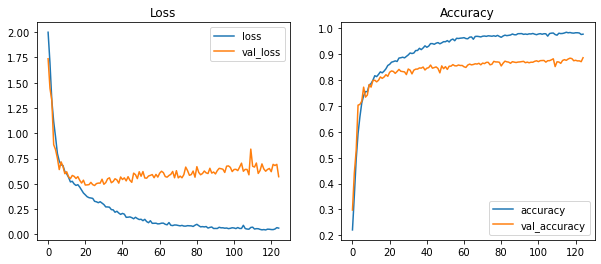

In [20]:
plot_history(history)

## Reduce overfitting - step 2
### Data Augmentation

In [21]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    image_augmented = tf.image.random_brightness(image_augmented, 0.25)
    image_augmented = tf.image.random_hue(image_augmented, 0.2)
    return image_augmented, label

In [22]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_train = data_train.map(lambda image, label: augment(image, label))
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

### Look into augmented data

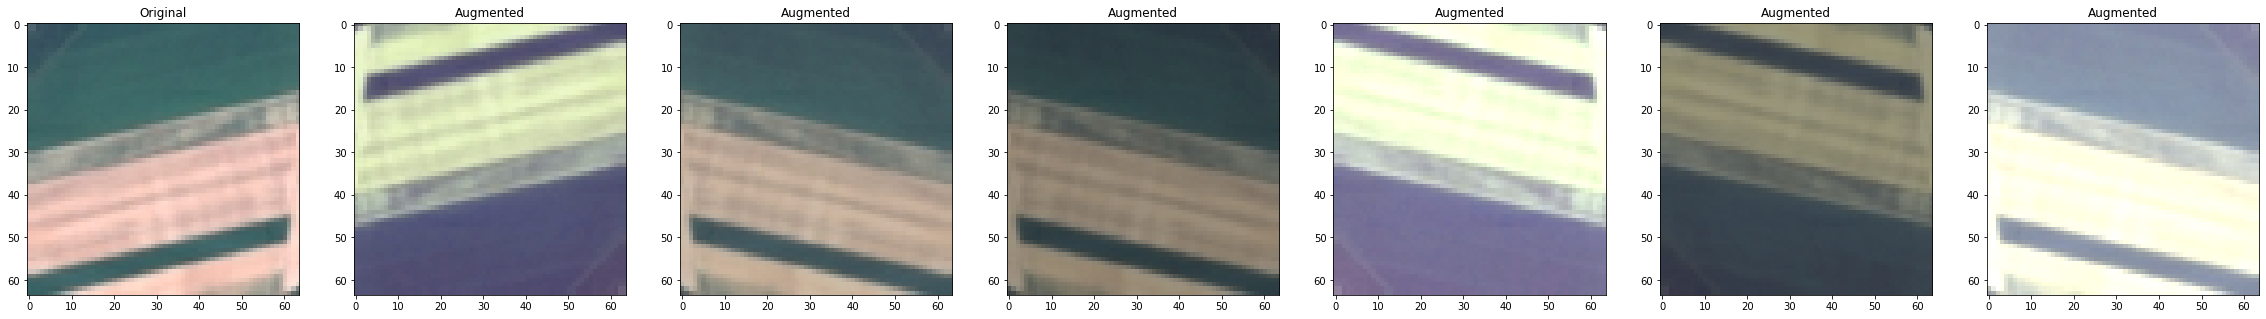

In [23]:
augment_limit = 6

plt.figure(figsize=(40,40))

image, label = list(dataset_train_raw.take(1))[0]
plt.subplot(1, augment_limit + 1, 1)
plt.imshow(image)
plt.title("Original")

for aug_index in range(augment_limit):
        
    image_augmented, label_augmented = list(data_train.take(1))[0]
    plt.subplot(1, augment_limit + 1, aug_index + 2)
    plt.imshow(image_augmented.numpy())
    plt.title("Augmented")

### Use the same architecture

In [24]:
model_3 = models.Sequential()

# Conv 32 block; kernel 3x3
model_3.add(layers.Conv2D(32, (3,3), activation="swish", padding="same", input_shape=(64, 64, 3)))
model_3.add(layers.Conv2D(32, (3,3), activation="swish", padding="same"))
model_3.add(layers.MaxPooling2D(2, 2))
model_3.add(layers.Dropout(0.2))

# Conv 64 block; kernel 3x3
model_3.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model_3.add(layers.Conv2D(64, (3,3), activation="swish", padding="same"))
model_3.add(layers.MaxPooling2D(2, 2))
model_3.add(layers.Dropout(0.3))

# Conv 128 block; kernel 3x3
model_3.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model_3.add(layers.Conv2D(128, (3,3), activation="swish", padding="same"))
model_3.add(layers.MaxPooling2D(2, 2))
model_3.add(layers.Dropout(0.4))

# Latent space
model_3.add(layers.Flatten())

# Classifier
model_3.add(layers.Dense(128, activation="swish"))
model_3.add(layers.Dropout(0.4))
model_3.add(layers.Dense(10, activation="softmax"))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)       

In [25]:
model_3.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [26]:
history = model_3.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["augmentation-with-dropout"] = history

Epoch 1/125
37/37 [==============================] - 10s 271ms/step - loss: 2.0961 - accuracy: 0.1997 - val_loss: 1.7444 - val_accuracy: 0.3667
Epoch 2/125
37/37 [==============================] - 9s 243ms/step - loss: 1.8924 - accuracy: 0.3046 - val_loss: 1.6241 - val_accuracy: 0.4030
Epoch 3/125
37/37 [==============================] - 9s 241ms/step - loss: 1.5926 - accuracy: 0.3936 - val_loss: 1.3890 - val_accuracy: 0.4931
Epoch 4/125
37/37 [==============================] - 9s 240ms/step - loss: 1.4214 - accuracy: 0.4680 - val_loss: 1.3196 - val_accuracy: 0.4810
Epoch 5/125
37/37 [==============================] - 9s 241ms/step - loss: 1.2543 - accuracy: 0.5420 - val_loss: 1.4609 - val_accuracy: 0.4780
Epoch 6/125
37/37 [==============================] - 9s 240ms/step - loss: 1.2699 - accuracy: 0.5346 - val_loss: 1.2047 - val_accuracy: 0.6264
Epoch 7/125
37/37 [==============================] - 9s 241ms/step - loss: 1.1132 - accuracy: 0.5971 - val_loss: 0.9447 - val_accuracy: 0.647

Epoch 58/125
37/37 [==============================] - 9s 253ms/step - loss: 0.4673 - accuracy: 0.8361 - val_loss: 0.4691 - val_accuracy: 0.8420
Epoch 59/125
37/37 [==============================] - 10s 259ms/step - loss: 0.4712 - accuracy: 0.8357 - val_loss: 0.4376 - val_accuracy: 0.8541
Epoch 60/125
37/37 [==============================] - 10s 264ms/step - loss: 0.4513 - accuracy: 0.8407 - val_loss: 0.4574 - val_accuracy: 0.8440
Epoch 61/125
37/37 [==============================] - 9s 250ms/step - loss: 0.4410 - accuracy: 0.8450 - val_loss: 0.4943 - val_accuracy: 0.8311
Epoch 62/125
37/37 [==============================] - 10s 273ms/step - loss: 0.4382 - accuracy: 0.8472 - val_loss: 0.4858 - val_accuracy: 0.8326
Epoch 63/125
37/37 [==============================] - 9s 245ms/step - loss: 0.4310 - accuracy: 0.8485 - val_loss: 0.4687 - val_accuracy: 0.8410
Epoch 64/125
37/37 [==============================] - 10s 268ms/step - loss: 0.4234 - accuracy: 0.8538 - val_loss: 0.5125 - val_accur

37/37 [==============================] - 11s 295ms/step - loss: 0.2759 - accuracy: 0.9003 - val_loss: 0.4057 - val_accuracy: 0.8699
Epoch 115/125
37/37 [==============================] - 11s 288ms/step - loss: 0.2658 - accuracy: 0.9065 - val_loss: 0.3415 - val_accuracy: 0.8936
Epoch 116/125
37/37 [==============================] - 11s 297ms/step - loss: 0.2679 - accuracy: 0.9072 - val_loss: 0.3651 - val_accuracy: 0.8901
Epoch 117/125
37/37 [==============================] - 11s 289ms/step - loss: 0.2650 - accuracy: 0.9090 - val_loss: 0.3449 - val_accuracy: 0.8943
Epoch 118/125
37/37 [==============================] - 11s 290ms/step - loss: 0.2673 - accuracy: 0.9085 - val_loss: 0.3455 - val_accuracy: 0.8916
Epoch 119/125
37/37 [==============================] - 11s 293ms/step - loss: 0.2637 - accuracy: 0.9079 - val_loss: 0.3625 - val_accuracy: 0.8859
Epoch 120/125
37/37 [==============================] - 11s 289ms/step - loss: 0.2551 - accuracy: 0.9136 - val_loss: 0.3791 - val_accuracy:

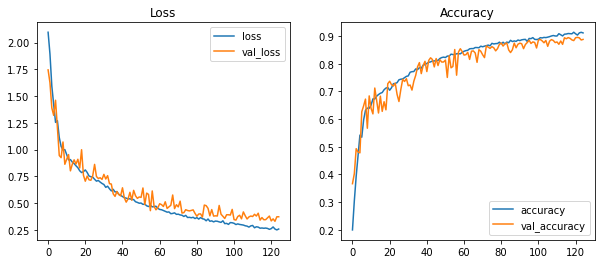

In [27]:
plot_history(history)

## Reduce overfitting - step 3
### Transfer learning - frozen pretrained model - feature extraction

In [28]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_train = data_train.map(lambda image, label: augment(image, label))
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

In [29]:
pretrained_model = applications.VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(64, 64, 3)
)

pretrained_model.trainable = False

pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [30]:
model_4 = models.Sequential()

model_4.add(pretrained_model)
model_4.add(layers.Flatten())

model_4.add(layers.Dense(2048, activation="relu"))
model_4.add(layers.Dropout(0.4))

model_4.add(layers.Dense(128, activation="relu"))
model_4.add(layers.Dropout(0.4))

model_4.add(layers.Dense(10, activation="softmax"))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [31]:
model_4.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_4.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["vgg19-frozen"] = history

Epoch 1/125
37/37 [==============================] - 101s 3s/step - loss: 1.5791 - accuracy: 0.4185 - val_loss: 1.0252 - val_accuracy: 0.6469
Epoch 2/125
37/37 [==============================] - 12s 331ms/step - loss: 1.1539 - accuracy: 0.5841 - val_loss: 0.8452 - val_accuracy: 0.7146
Epoch 3/125
37/37 [==============================] - 12s 331ms/step - loss: 1.0106 - accuracy: 0.6387 - val_loss: 0.8327 - val_accuracy: 0.6622
Epoch 4/125
37/37 [==============================] - 12s 330ms/step - loss: 0.9521 - accuracy: 0.6661 - val_loss: 0.7396 - val_accuracy: 0.7412
Epoch 5/125
37/37 [==============================] - 12s 330ms/step - loss: 0.9094 - accuracy: 0.6776 - val_loss: 0.7453 - val_accuracy: 0.7427
Epoch 6/125
37/37 [==============================] - 12s 333ms/step - loss: 0.8634 - accuracy: 0.6976 - val_loss: 0.6674 - val_accuracy: 0.7684
Epoch 7/125
37/37 [==============================] - 12s 331ms/step - loss: 0.8327 - accuracy: 0.7086 - val_loss: 0.6963 - val_accuracy: 0

37/37 [==============================] - 10s 277ms/step - loss: 0.6056 - accuracy: 0.7894 - val_loss: 0.5043 - val_accuracy: 0.8254
Epoch 58/125
37/37 [==============================] - 10s 276ms/step - loss: 0.6120 - accuracy: 0.7838 - val_loss: 0.5590 - val_accuracy: 0.8035
Epoch 59/125
37/37 [==============================] - 10s 279ms/step - loss: 0.6130 - accuracy: 0.7859 - val_loss: 0.5306 - val_accuracy: 0.8121
Epoch 60/125
37/37 [==============================] - 11s 295ms/step - loss: 0.6043 - accuracy: 0.7856 - val_loss: 0.5535 - val_accuracy: 0.8096
Epoch 61/125
37/37 [==============================] - 11s 301ms/step - loss: 0.5996 - accuracy: 0.7910 - val_loss: 0.5421 - val_accuracy: 0.8205
Epoch 62/125
37/37 [==============================] - 11s 285ms/step - loss: 0.6094 - accuracy: 0.7865 - val_loss: 0.5437 - val_accuracy: 0.8178
Epoch 63/125
37/37 [==============================] - 11s 296ms/step - loss: 0.6066 - accuracy: 0.7879 - val_loss: 0.5413 - val_accuracy: 0.814

37/37 [==============================] - 12s 326ms/step - loss: 0.5656 - accuracy: 0.8027 - val_loss: 0.5280 - val_accuracy: 0.8215
Epoch 114/125
37/37 [==============================] - 12s 332ms/step - loss: 0.5614 - accuracy: 0.8047 - val_loss: 0.5510 - val_accuracy: 0.8173
Epoch 115/125
37/37 [==============================] - 12s 325ms/step - loss: 0.5566 - accuracy: 0.8008 - val_loss: 0.4994 - val_accuracy: 0.8311
Epoch 116/125
37/37 [==============================] - 12s 337ms/step - loss: 0.5469 - accuracy: 0.8071 - val_loss: 0.5274 - val_accuracy: 0.8212
Epoch 117/125
37/37 [==============================] - 12s 327ms/step - loss: 0.5648 - accuracy: 0.8029 - val_loss: 0.5009 - val_accuracy: 0.8277
Epoch 118/125
37/37 [==============================] - 12s 333ms/step - loss: 0.5578 - accuracy: 0.8037 - val_loss: 0.5164 - val_accuracy: 0.8240
Epoch 119/125
37/37 [==============================] - 12s 325ms/step - loss: 0.5656 - accuracy: 0.8015 - val_loss: 0.5054 - val_accuracy:

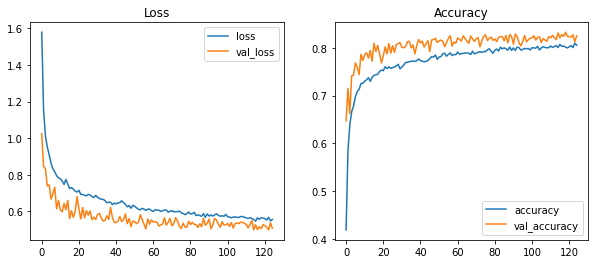

In [32]:
plot_history(history)

## Reduce overfitting - step 4

### Transfer learning with partially unfrozen, pre-trained model - Fine-tuning

In [33]:
data_train = dataset_train_raw.map(lambda image, label: encode(image, label)).cache()
data_train = data_train.map(lambda image, label: augment(image, label))
data_validate = dataset_validate_raw.map(lambda image, label: encode(image, label)).cache()
data_test = dataset_test_raw.map(lambda image, label: encode(image, label)).cache()

In [34]:
pretrained_model = applications.VGG19(
    weights="imagenet", 
    include_top=False, 
    input_shape=(64, 64, 3)
)

pretrained_model.trainable = True
set_trainable = False

for layer in pretrained_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
        
    layer.trainable = set_trainable
    
pretrained_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [35]:
model_5 = models.Sequential()

model_5.add(pretrained_model)
model_5.add(layers.Flatten())

model_5.add(layers.Dense(2048, activation="relu"))
model_5.add(layers.Dropout(0.4))

model_5.add(layers.Dense(128, activation="relu"))
model_5.add(layers.Dropout(0.4))

model_5.add(layers.Dense(10, activation="softmax"))

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [36]:
model_5.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_5.fit(
    data_train.shuffle(10_000).batch(batch_size),
    epochs=epochs,
    validation_data=data_validate.batch(batch_size)
)

histories["vgg19-partially-unfrozen"] = history

Epoch 1/125
37/37 [==============================] - 24s 650ms/step - loss: 2.1559 - accuracy: 0.1823 - val_loss: 1.6885 - val_accuracy: 0.3015
Epoch 2/125
37/37 [==============================] - 14s 367ms/step - loss: 1.5808 - accuracy: 0.3833 - val_loss: 1.2458 - val_accuracy: 0.5281
Epoch 3/125
37/37 [==============================] - 13s 357ms/step - loss: 1.1810 - accuracy: 0.5647 - val_loss: 1.0123 - val_accuracy: 0.6257
Epoch 4/125
37/37 [==============================] - 14s 367ms/step - loss: 0.9721 - accuracy: 0.6513 - val_loss: 0.7053 - val_accuracy: 0.7583
Epoch 5/125
37/37 [==============================] - 13s 359ms/step - loss: 0.8230 - accuracy: 0.7148 - val_loss: 0.6331 - val_accuracy: 0.7889
Epoch 6/125
37/37 [==============================] - 13s 365ms/step - loss: 0.7695 - accuracy: 0.7410 - val_loss: 0.5657 - val_accuracy: 0.8148
Epoch 7/125
37/37 [==============================] - 13s 357ms/step - loss: 0.6847 - accuracy: 0.7683 - val_loss: 0.6006 - val_accuracy:

37/37 [==============================] - 14s 366ms/step - loss: 0.2358 - accuracy: 0.9218 - val_loss: 0.4280 - val_accuracy: 0.8867
Epoch 58/125
37/37 [==============================] - 14s 366ms/step - loss: 0.2578 - accuracy: 0.9143 - val_loss: 0.3820 - val_accuracy: 0.9020
Epoch 59/125
37/37 [==============================] - 14s 369ms/step - loss: 0.2336 - accuracy: 0.9242 - val_loss: 0.4386 - val_accuracy: 0.8879
Epoch 60/125
37/37 [==============================] - 13s 361ms/step - loss: 0.2455 - accuracy: 0.9179 - val_loss: 0.4102 - val_accuracy: 0.8842
Epoch 61/125
37/37 [==============================] - 13s 364ms/step - loss: 0.2408 - accuracy: 0.9219 - val_loss: 0.5035 - val_accuracy: 0.8694
Epoch 62/125
37/37 [==============================] - 13s 362ms/step - loss: 0.2521 - accuracy: 0.9159 - val_loss: 0.3812 - val_accuracy: 0.8988
Epoch 63/125
37/37 [==============================] - 14s 365ms/step - loss: 0.2313 - accuracy: 0.9221 - val_loss: 0.3950 - val_accuracy: 0.891

37/37 [==============================] - 11s 300ms/step - loss: 0.1740 - accuracy: 0.9424 - val_loss: 0.5284 - val_accuracy: 0.8985
Epoch 114/125
37/37 [==============================] - 11s 300ms/step - loss: 0.1678 - accuracy: 0.9435 - val_loss: 0.5078 - val_accuracy: 0.8953
Epoch 115/125
37/37 [==============================] - 11s 299ms/step - loss: 0.1623 - accuracy: 0.9461 - val_loss: 0.5377 - val_accuracy: 0.8748
Epoch 116/125
37/37 [==============================] - 11s 300ms/step - loss: 0.1594 - accuracy: 0.9462 - val_loss: 0.5949 - val_accuracy: 0.8844
Epoch 117/125
37/37 [==============================] - 11s 301ms/step - loss: 0.1824 - accuracy: 0.9386 - val_loss: 0.4900 - val_accuracy: 0.8901
Epoch 118/125
37/37 [==============================] - 11s 300ms/step - loss: 0.1673 - accuracy: 0.9431 - val_loss: 0.4923 - val_accuracy: 0.8904
Epoch 119/125
37/37 [==============================] - 11s 307ms/step - loss: 0.1645 - accuracy: 0.9451 - val_loss: 0.4543 - val_accuracy:

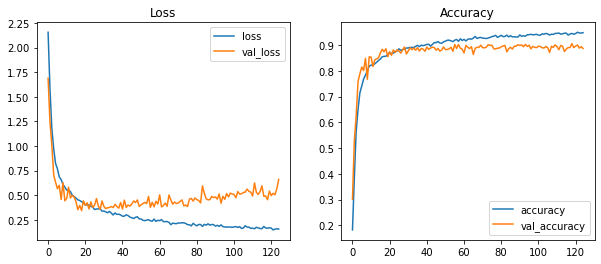

In [37]:
plot_history(history)

## Summary of results

### Models' comparison

Text(0.5, 1.0, 'Validation Accuracy')

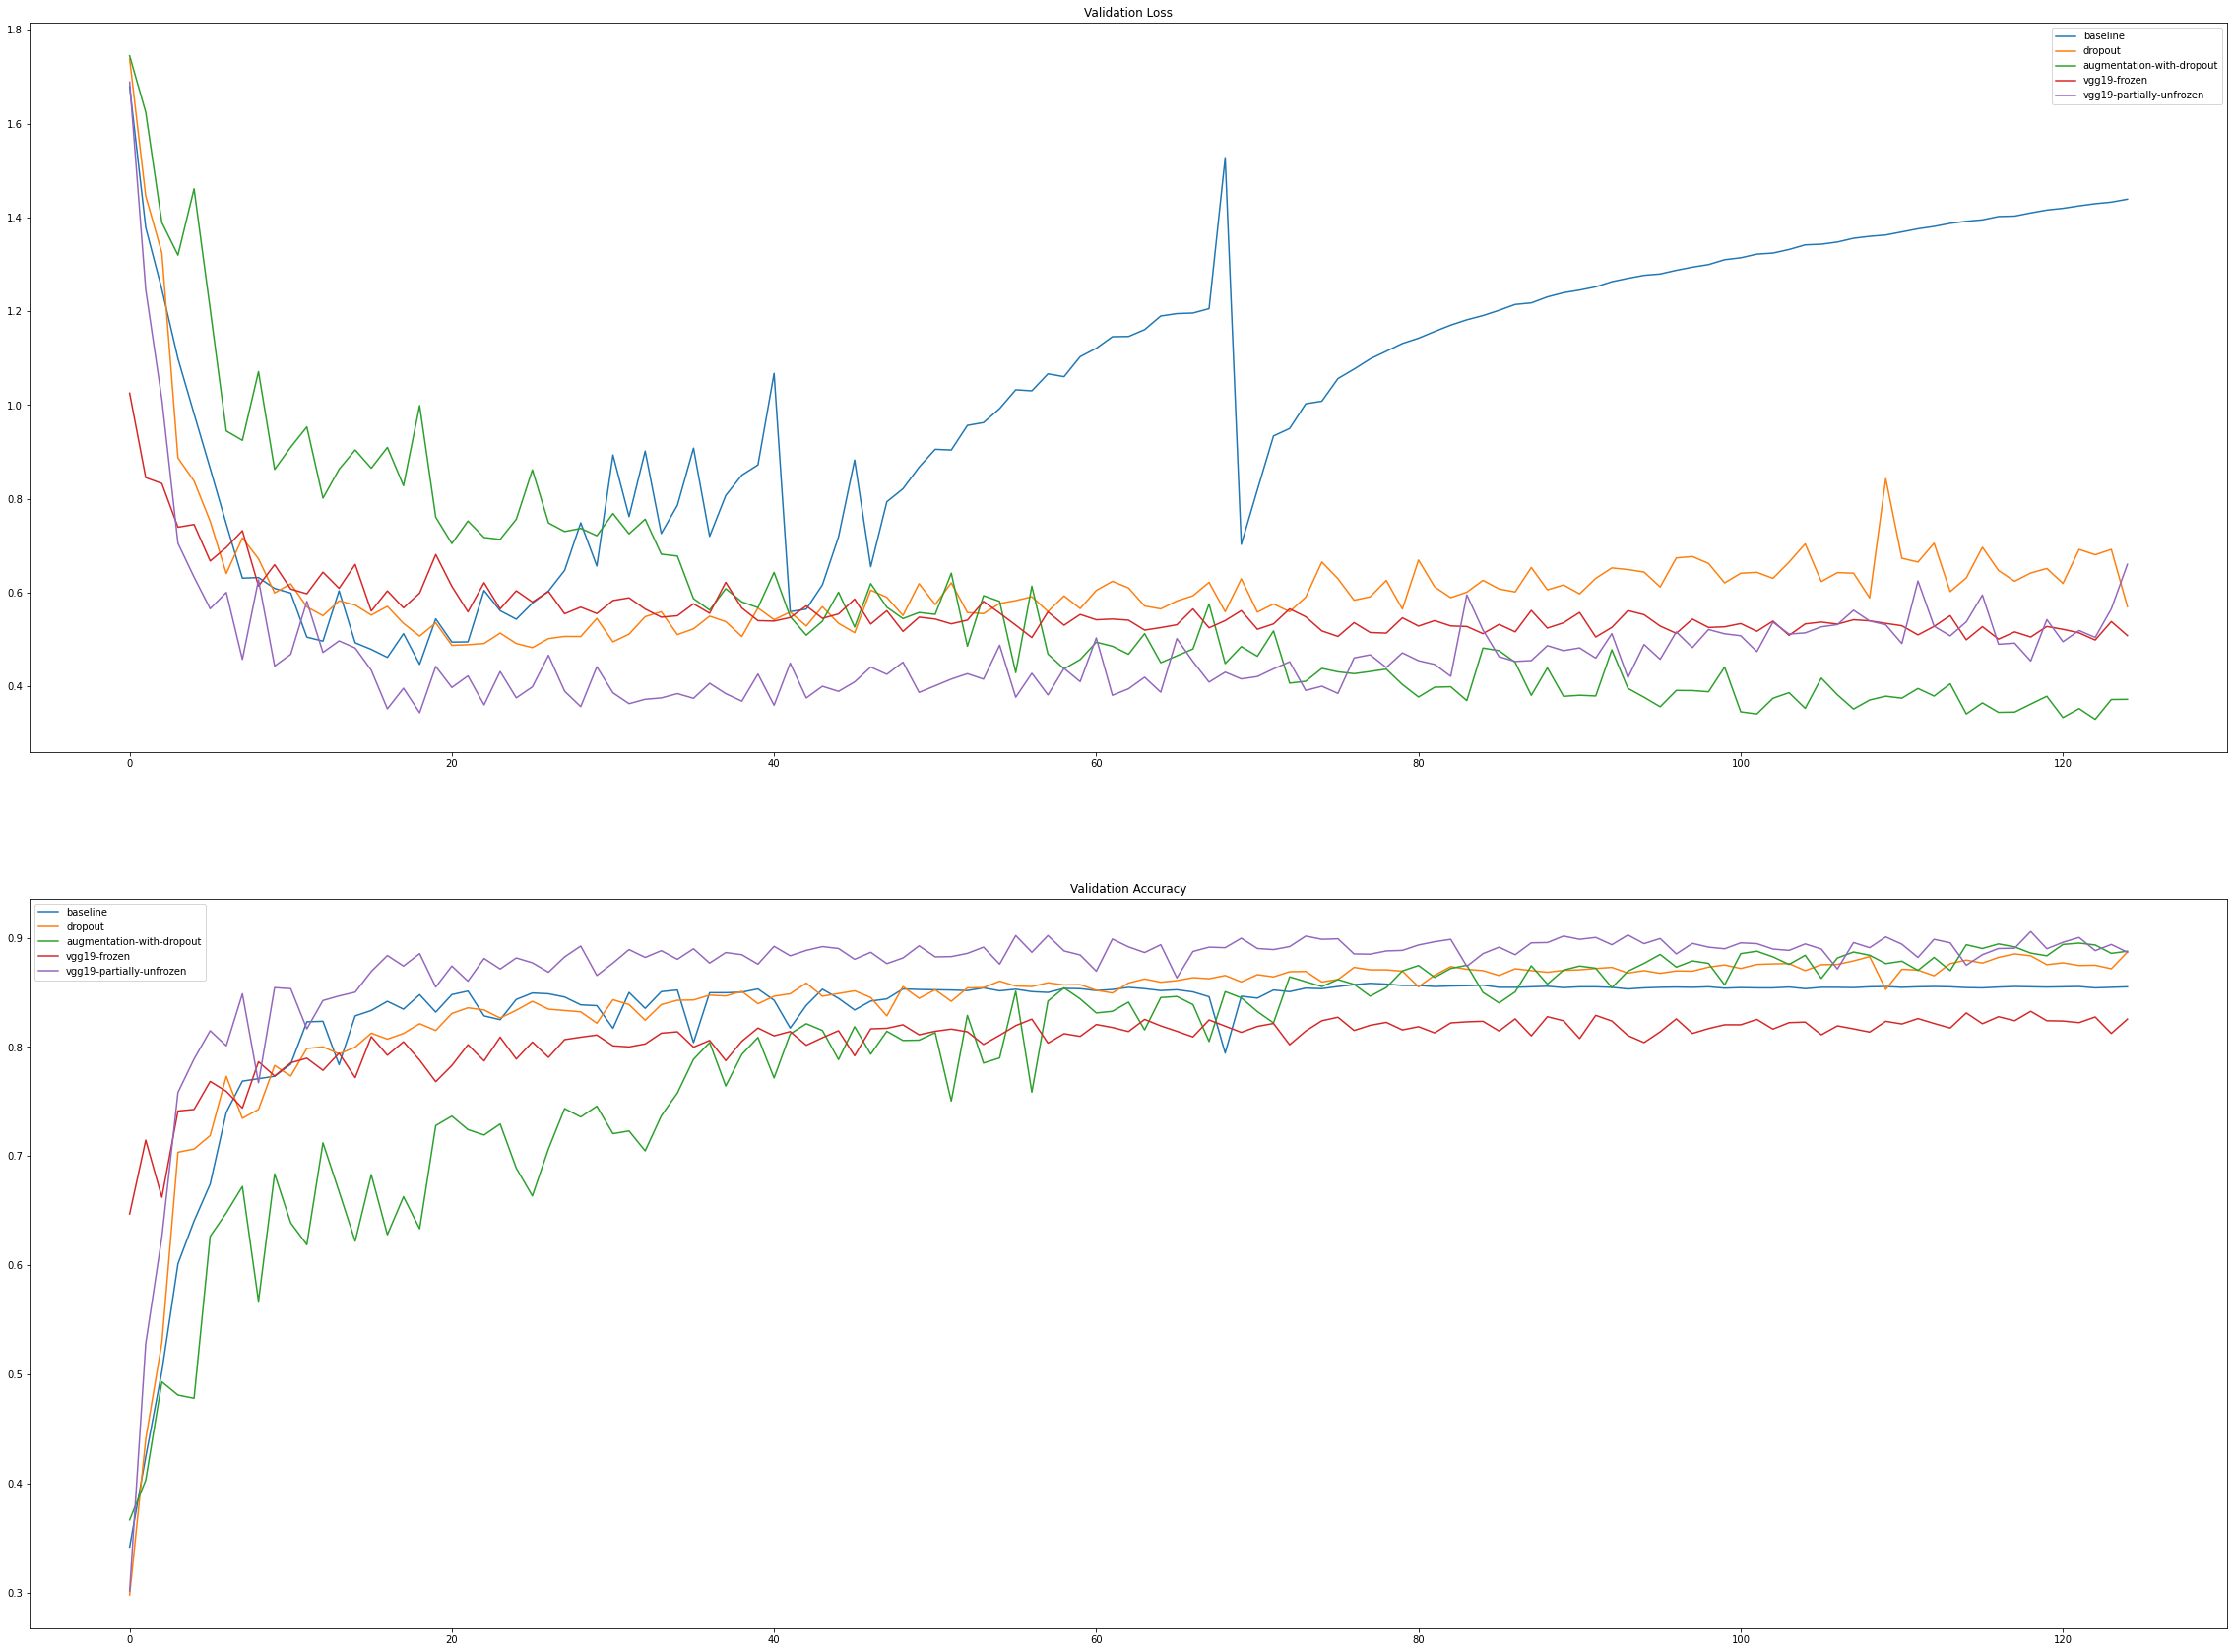

In [38]:
plt.figure(figsize=(40, 30))
  
plt.subplot(2, 1, 1)
for title, history in histories.items():
    plt.plot(history.history["val_loss"], label=title)
    
plt.legend()
plt.title("Validation Loss")


plt.subplot(2, 1, 2)
for title, history in histories.items():
    plt.plot(history.history["val_accuracy"], label=title)
    
plt.legend()
plt.title("Validation Accuracy")